# Project Notebook

This project notebook replicates the work presented in the final report (ADD LINK).

#### Imports

In [111]:
# Basics
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical libraries
from scipy.stats import norm, chi2

# Custom utils functions
import sys; sys.path.append("./libraries/")
from utils import *

#### Settings

In [2]:
# Relative Paths
RAW_DATA = "../data/raw/"
PROC_DATA = "../data/processed/"

# Flags
process = False

# Replace files
write_2_disk = False

# Seed for reproducibility
seed = 7

# Set the style for plots
sns.set_style("whitegrid")

# Data

## Load and match datasets
We have two different dataset sources with different identifiers. To match players from Transfermarkt with their attributes from soFIFA, we use a custom function that looks at their names, date of birth and nationality to ensure they are the same player.

In [3]:
# If process, load raw data and apply matching between datasets
# NOTE: It may take several minutes
if process:
    # Raw player's datasets
    transfermarkt = pd.read_csv('https://query.data.world/s/gksm6hx4xzgjaed7tia2uzpafwvyjo?dws=00000')
    fifa22 = pd.read_csv(RAW_DATA + "FIFA22_player_ratings.csv") # FIFA player attributes from 2022
    fifas21 = pd.read_csv(RAW_DATA + "FIFA21_player_ratings.csv") # FIFA player attributes from 2022
    # This appends players from 2021 not present in 2022
    extended = set(fifas21.sofifa_id).difference(set(fifa22.sofifa_id))
    FIFA = pd.concat([fifa22, fifas21[fifas21.sofifa_id.isin(extended)]]).reset_index()

    # Remove uninformative columns
    transfermarkt.drop(["player_code", "agent_name", "image_url", "url"], axis=1, inplace=True)
    FIFA.drop(["player_url", "club_team_id", "club_position", "club_jersey_number", "club_loaned_from", "club_joined", 
                "nationality_id", "nation_team_id", "nation_jersey_number", "real_face", "player_tags", "player_face_url", 
                "club_logo_url", "club_flag_url", "nation_logo_url", "nation_flag_url"], axis=1, inplace=True)
    
    # Find matches using custom function
    longname_matches = match_players(transfermarkt, FIFA)
    # Append the extracted FIFA long names
    transfermarkt["FIFA_long_name"] = longname_matches

    ## Merge players with FIFA attributes
    # Create a unique identifier with long name and year of birth
    transfermarkt["fifa_id"] = transfermarkt["FIFA_long_name"] + "-" + pd.to_datetime(transfermarkt["date_of_birth"]).dt.year.astype(str)
    FIFA["fifa_id"] = FIFA.long_name + "-" + pd.to_datetime(FIFA["dob"]).dt.year.astype(str)
    # Join
    players = transfermarkt.merge(FIFA, on="fifa_id", how="inner")
    # Drop temp id cols
    players.drop(["name", "fifa_id", "sofifa_id"], axis=1, inplace=True)
    # Save dataset
    players.to_csv(PROC_DATA + "players_wFIFAattributes.csv", index=False)

# Else load processed data
else:
    players = pd.read_csv(PROC_DATA + "players_wFIFAattributes.csv")

# Get valuation data
valuations = pd.read_csv('https://query.data.world/s/y4qg2twfvou4w2ghz6o3evju32g7yn?dws=00000') 
# ... (we can get some more datasets if needed)

# Glance at data
print(players.info())
players.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11159 entries, 0 to 11158
Columns: 112 entries, player_id to gk
dtypes: float64(15), int64(44), object(53)
memory usage: 9.5+ MB
None


,player_id,first_name,last_name,FIFA_long_name,last_season,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,3875,Jermain,Defoe,Jermain Colin Defoe,2021,England,London,England,1982-10-07,Centre-Forward,...,43+2,43+2,43+2,43+2,40+2,38+2,38+2,38+2,40+2,18+2
1,4742,Christophe,Lepoint,Christophe Lepoint,2022,Belgium,Brussel,Belgium,1984-10-24,Central Midfield,...,68-1,68-1,68-1,62+2,62+2,67,67,67,62+2,16+2
2,6838,Henok,Goitom,Henok Goitom,2015,Sweden,Solna,Eritrea,1984-09-22,Centre-Forward,...,55+2,55+2,55+2,50+2,48+2,50+2,50+2,50+2,48+2,17+2
3,10003,Wes,Morgan,Wes Morgan,2020,England,Nottingham,Jamaica,1984-01-21,Centre-Back,...,64+2,64+2,64+2,54+2,57+2,73,73,73,57+2,16+2
4,10471,NaN,Luiz Gustavo,Luiz Gustavo Dias,2021,Brazil,Pindamonhangaba,Brazil,1987-07-23,Defensive Midfield,...,75+2,75+2,75+2,71+3,71+3,75+2,75+2,75+2,71+3,17+3


# EDA
TODO

We can also plot the histogram of all players' age in the Transfermarkt dataset, to get a sense of the age distribution across players.

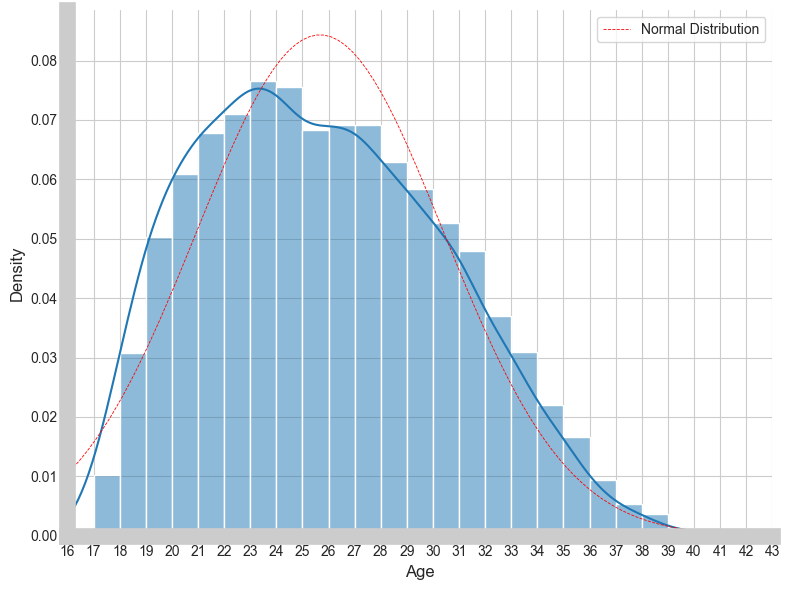

In [129]:
fig, ax = plt.subplots(figsize=(8,6))
plt.rcParams['axes.linewidth'] = 12

# Plot the histogram of ages
sns.histplot(data=players, x="age", kde=True, stat="density", bins=np.arange(players.age.min(), players.age.max() + 1), ax=ax)

# Fit a normal distribution to the data
mu, std = np.mean(players.age), np.std(players.age)
xmin, xmax = plt.xlim(players.age.min(), players.age.max())
plt.xticks(players.age.unique())
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, '--r', linewidth=0.6, label='Normal Distribution')

# Add labels
plt.xlabel('Age', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.tight_layout()

sns.despine(ax=ax, top=True, right=True)
# Show the plot
plt.show()

The data appears roughly normally distributed, with a slight right tail. To test for a normal distribution fit, we use a Chi-square goodness of fit test, with an alpha level of 0.05. The chi-square test (Snedecor and Cochran, 1989) is used to test if a sample of data came from a population with a specific distribution. <br>
$H_0$:	The data follow a specified distribution (i.e., Normal). <br>
$H_a$:	The data do not follow the specified distribution.


In [5]:
# Select an alpha level
alpha = 0.05

# Total observations
N = players.shape[0]

# Parameters for the normal distribution (mean and standard deviation)
mean_age = np.mean(players.age)
std_age = np.std(players.age)

# Range of ages
ages = pd.Series(np.arange(players.age.min(), players.age.max()+1))

# Calculate the probability function for each age
expected_frequencies = N * norm.pdf(ages, loc=players.age.mean(), scale=players.age.std())

# Get the observed frequencies
observed_frequencies = players.groupby("age").size()

# Perform the chi-squared test
chi2_stat, p_value, dof, expected = chi2_contingency([observed_frequencies, expected_frequencies])

print(f"Chi-squared Statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")

if p_value < alpha:
    print("We reject the null hypothesis, and thus conclude the distribution is not normal.")
else:
    print("We cannot reject the null hypothesis, and thus it can be possible that the distribution is normal.")

Chi-squared Statistic: 330.2726147151785
P-value: 6.398325123547772e-54
Degrees of Freedom: 27
We reject the null hypothesis, and thus conclude the distribution is not normal.


# Survival Analysis
The first step is to recognize retired players. We apply the assumption that a player is retired if he hasn't played for over a year, has no current club, no market value and no contract.

In [6]:
# Detect retired:
## Conditions:
### Last season < 2021
### No current club (NAN)
### No Market value in EUR (NAN)
### No Contract Expiration date (NAN)

# Use custom function generate boolean flag for "Retired" players
players = detect_retired(players)

# A glance to the retire players
players[players.retired].head()

,player_id,first_name,last_name,FIFA_long_name,last_season,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,...,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,retired
13,26105,Valter,Birsa,Valter Birsa,2019,Jugoslawien (SFR),Sempeter pri Gorici,Slovenia,1986-08-07,Attacking Midfield,...,64+2,64+2,63+2,60+2,59+2,59+2,59+2,60+2,11+2,True
32,42086,Timo,Perthel,Timo Perthel,2013,Germany,Kaiserslautern,Germany,1989-02-11,Left-Back,...,64+2,64+2,65+1,64+2,64+2,64+2,64+2,64+2,15+2,True
57,56820,Jérémy,Sorbon,Jérémy Sorbon,2018,France,Caen,France,1983-08-05,Centre-Back,...,64+2,64+2,59+2,60+2,69,69,69,60+2,17+2,True
73,62240,Maynor,Figueroa,Maynor Alexis Figueroa Róchez,2014,Honduras,Jutiapa,Honduras,1983-05-02,Left-Back,...,66+2,66+2,63+2,63+2,68,68,68,63+2,17+2,True
119,101922,Fabio,Pisacane,Fabio Pisacane,2020,Italy,Napoli,Italy,1986-01-28,Centre-Back,...,65+2,65+2,66+2,67+2,70,70,70,67+2,19+2,True


Now are all players in the dataset contain a "retired" flag.

## FOOTBALL PLAYERS PROFESSIONAL LIFE TABLE
Similar to the life tables in traditional Survival Analysis, the "professional life" table will compute the probability of retiring ('h') at a given age (based on their frequency), and a "Activity" ('A') probability at a given age, computed as the probability of NOT being retired at that age.

In [7]:
retire_table = get_retire_table(players, ci=(0.025, 0.975), bootstrap_settings={"simulations": 10000})

c:\Users\ginof\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'A_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


In [8]:
retire_table

,age,n,retired,h,A,0.025,0.975,e
0,16,9,0,0.000000,1.000000,1.000000,1.000000,21.014007
1,17,115,0,0.000000,1.000000,1.000000,1.000000,20.014007
2,18,344,2,0.005814,0.994186,0.984848,1.000000,19.014007
3,19,562,4,0.007117,0.987110,0.975577,0.996491,18.019821
4,20,680,7,0.010294,0.976949,0.963174,0.989076,17.032711
5,21,757,3,0.003963,0.973077,0.958852,0.985866,16.055763
6,22,793,4,0.005044,0.968169,0.953079,0.981859,15.082686
7,23,855,4,0.004678,0.963639,0.948122,0.978000,14.114517
8,24,843,1,0.001186,0.962496,0.946891,0.977170,13.150878
9,25,763,4,0.005242,0.957450,0.941115,0.972550,12.188382


In [9]:
# TEMP CODE TO WRITE TABLE AS LATEX
dtypes= {k: int for k in retire_table.columns[:3]}
dtypes.update({k: float for k in retire_table.columns[3:]})
write_latex_table(retire_table, dtypes=dtypes)

Let's plot the survival curve with the confidence intervals.

''

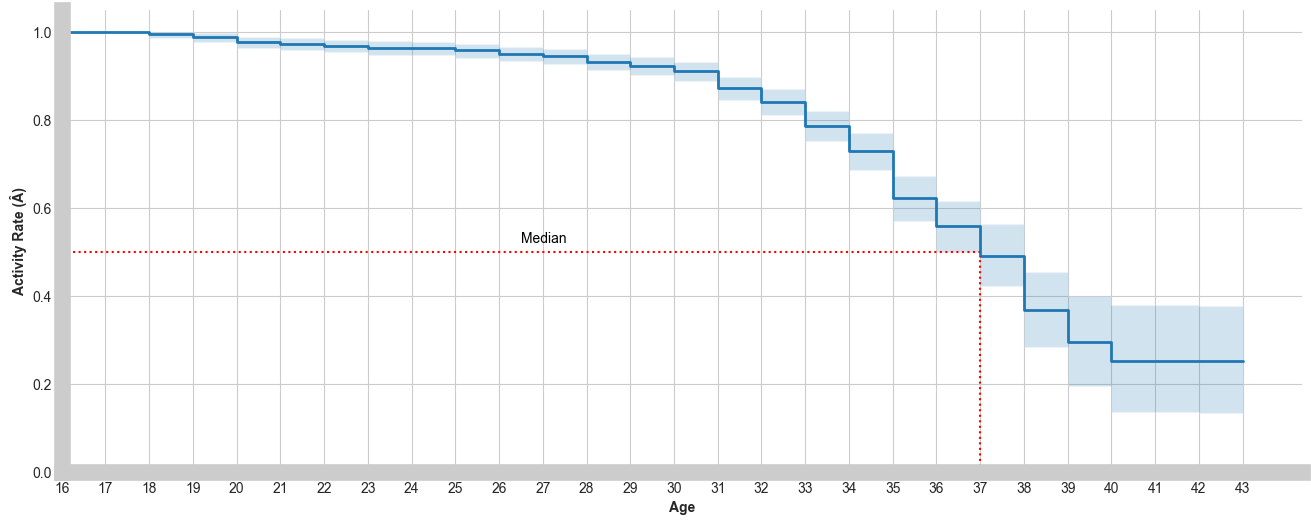

In [76]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.rcParams['axes.linewidth'] = 12

# Plot Survival curve
sns.lineplot(data=retire_table, x="age", y="A", drawstyle="steps-post", linewidth=2, ax=ax)
# Plot Conf. Intervals
ax.fill_between(retire_table.age, retire_table[0.025], retire_table[0.975], alpha=0.2, step="post", label="Confidence Interval")
# Find the intersection between the curve and the 50%
xmin = retire_table.age.min()
x_50, y_50 = retire_table.iloc[(retire_table['A']-0.5).abs().argsort()[:1], 0].values[0], retire_table.iloc[(retire_table['A']-0.5).abs().argsort()[:1], 4].values[0]
ax.hlines(y = 0.5, xmin=xmin , xmax = x_50, color= 'r', linestyles='dotted')
ax.vlines(x = x_50, ymin=0 , ymax = y_50, color= 'r', linestyles='dotted')
ax.text(xmin+(x_50-xmin)/2, 0.52,"Median", color="black", alpha=1)
ax.set_xlim(retire_table.age.min())
ax.set_ylim(0)
ax.set_xticks(retire_table.age)
ax.set_xlabel("Age", weight="bold") 
ax.set_ylabel("Activity Rate (Â)", weight="bold")
sns.despine(ax=ax, top=True, right=True)
;

Let's see if there are differences between three groups of players: Lean, Normal and Stocky.

In [138]:
lean, normal, stocky = players[players.body_type.str.contains("Lean")], players[players.body_type.str.contains("Normal")], players[players.body_type.str.contains("Stocky")]

retire_table_lean, retire_table_normal, retire_table_stocky = get_retire_table(lean, bootstrap_settings={"simulations": 10}), \
    get_retire_table(normal, bootstrap_settings={"simulations": 10}), \
    get_retire_table(stocky, bootstrap_settings={"simulations": 10}),

c:\Users\ginof\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'A_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.rcParams['axes.linewidth'] = 12

# Plot Survival curve
sns.lineplot(data=retire_table, x="age", y="A", drawstyle="steps-post", linewidth=2, ax=ax)
# Plot Conf. Intervals
ax.fill_between(retire_table.age, retire_table[0.025], retire_table[0.975], alpha=0.2, step="post", label="Confidence Interval")
# Find the intersection between the curve and the 50%
xmin = retire_table.age.min()
x_50, y_50 = retire_table.iloc[(retire_table['A']-0.5).abs().argsort()[:1], 0].values[0], retire_table.iloc[(retire_table['A']-0.5).abs().argsort()[:1], 4].values[0]
ax.hlines(y = 0.5, xmin=xmin , xmax = x_50, color= 'r', linestyles='dotted')
ax.vlines(x = x_50, ymin=0 , ymax = y_50, color= 'r', linestyles='dotted')
ax.text(xmin+(x_50-xmin)/2, 0.52,"Median", color="black", alpha=1)
ax.set_xlim(retire_table.age.min())
ax.set_ylim(0)
ax.set_xticks(retire_table.age)
ax.set_xlabel("Age", weight="bold") 
ax.set_ylabel("Activity Rate (Â)", weight="bold")
sns.despine(ax=ax, top=True, right=True)

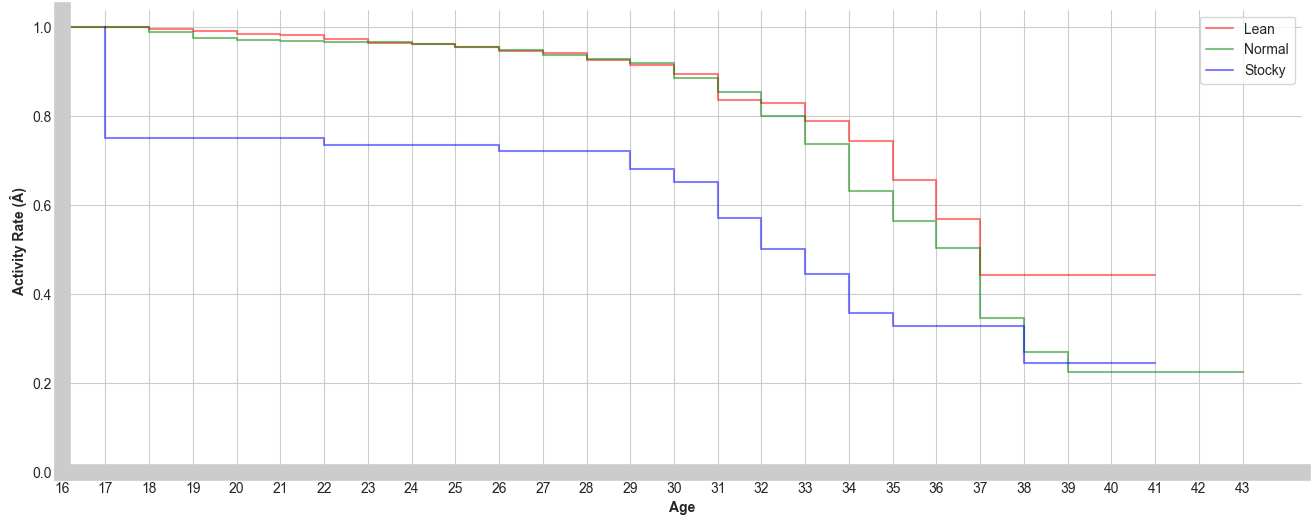

In [141]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.rcParams['axes.linewidth'] = 12

legend = ["Lean", "Normal", "Stocky"]


sns.lineplot(data= retire_table_lean, x="age", y= "A", drawstyle="steps-post", color="red", alpha=0.5, ax=ax, errorbar=None)
sns.lineplot(data= retire_table_normal, x="age", y= "A", drawstyle="steps", color="green", alpha=0.5, ax=ax, errorbar=None)
sns.lineplot(data= retire_table_stocky, x="age", y= "A", drawstyle="steps", color="blue", alpha=0.5, ax=ax, errorbar=None)

ax.set_xlim(retire_table.age.min())
ax.set_ylim(0)
ax.set_xticks(retire_table.age)

plt.legend(legend)
ax.set_xlabel("Age", weight="bold") 
ax.set_ylabel("Activity Rate (Â)", weight="bold")
sns.despine()
plt.show()

In [82]:
players_low, players_high = players[players.work_rate.isin(["Low/Low", "Low/Medium", "Medium/Low"])], players[players.work_rate.isin(["High/High", "High/Medium", "Medium/High"])]

retire_table_low, retire_table_high = get_retire_table(players_low), get_retire_table(players_high)

c:\Users\ginof\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'A_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


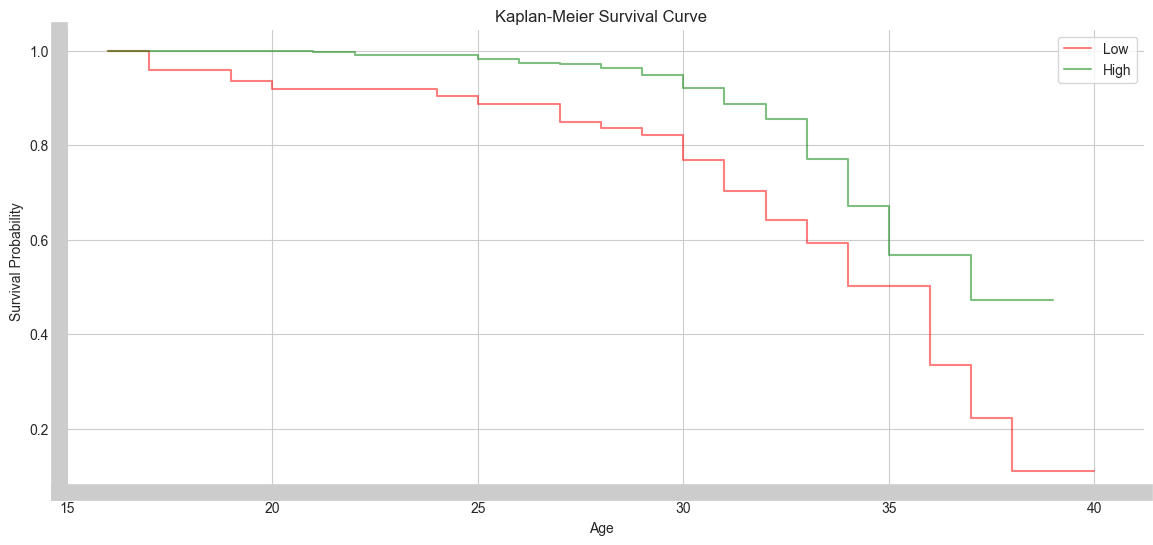

In [88]:
fig, ax = plt.subplots(figsize=(14,6))

legend = ["Low", "High"]


sns.lineplot(data= retire_table_low, x="age", y= "A", drawstyle="steps", color="red", alpha=0.5, ax=ax, errorbar=None)
sns.lineplot(data= retire_table_high, x="age", y= "A", drawstyle="steps", color="green", alpha=0.5, ax=ax, errorbar=None)

plt.title('Kaplan-Meier Survival Curve')
plt.legend(legend)
plt.xlabel('Age')
plt.ylabel('Survival Probability')
sns.despine()
plt.show()

# Log-Rank Test

We calculate the Log-Rank test to assess the difference between players with high work rate and low work rate in their active curve.

In [108]:
# Join both tables
joined = retire_table_high.merge(retire_table_low, on="age", how="left", suffixes=["_A", "_B"])

# Calculate the expected number of retire players under the null hypothesis
# Expected number of retired players at a given age for each group:
    # Total number of player at age i * Total number of retired players at age i / Total number of players for both groups
joined["expected_A"] = (joined["n_A"]) * (joined["retired_A"] + joined["retired_B"]) / (joined["n_A"] + joined["n_B"])
joined["expected_B"] = (joined["n_B"]) * (joined["retired_A"] + joined["retired_B"]) / (joined["n_A"] + joined["n_B"])

Calculate the Chi2 statistic.

In [109]:
stat = (joined.retired_A.sum() - joined.expected_A.sum())**2 / joined.expected_A.sum() + (joined.retired_B.sum() - joined.expected_B.sum())**2 / joined.expected_B.sum()

Compare the statistic with the chosen significance level ($\alpha = 0.05$)

In [113]:
alpha = 0.05
p_value = 1-chi2.cdf(stat, df=1)

if p_value < alpha:
    print(f"With P-Value of {p_value}, we reject the null hypothesis of equal curves.")
else:
    print(f"With P-Value of {p_value}, we fail to reject the null hypothesis of equal curves.")

With P-Value of 0.003927830235524454, we reject the null hypothesis of equal curves.


We calculate now among different body types: Lean vs Stocky

In [149]:
# Join both tables
non_stocky = players[~players.body_type.str.contains("Stocky")]
retire_table_non_stocky = get_retire_table(non_stocky, bootstrap_settings={"simulations": 10})

joined = retire_table_stocky.merge(retire_table_non_stocky, on="age", how="left", suffixes=["_A", "_B"])

# Calculate the expected number of retire players under the null hypothesis
# Expected number of retired players at a given age for each group:
    # Total number of player at age i * Total number of retired players at age i / Total number of players for both groups
joined["expected_A"] = (joined["n_A"]) * (joined["retired_A"] + joined["retired_B"]) / (joined["n_A"] + joined["n_B"])
joined["expected_B"] = (joined["n_B"]) * (joined["retired_A"] + joined["retired_B"]) / (joined["n_A"] + joined["n_B"])
    

c:\Users\ginof\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'A_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


In [150]:
stat = (joined.retired_A.sum() - joined.expected_A.sum())**2 / joined.expected_A.sum() + (joined.retired_B.sum() - joined.expected_B.sum())**2 / joined.expected_B.sum()

alpha = 0.05
p_value = 1-chi2.cdf(stat, df=1)

if p_value < alpha:
    print(f"With P-Value of {p_value}, we reject the null hypothesis of equal curves.")
else:
    print(f"With P-Value of {p_value}, we fail to reject the null hypothesis of equal curves.")

With P-Value of 0.0569599656281472, we fail to reject the null hypothesis of equal curves.


# Lasso regression using Activity Rate

In [157]:
players[["long_name", "value_eur", "market_value_in_eur"]]

,long_name,value_eur,market_value_in_eur
0,Jermain Colin Defoe,400000.0,NaN
1,Christophe Lepoint,400000.0,75000.0
2,Henok Goitom,350000.0,NaN
3,Wes Morgan,550000.0,NaN
4,Luiz Gustavo Dias,5000000.0,1000000.0
...,...,...,...
11154,Karim-David Adeyemi,4500000.0,35000000.0
11155,Josh Reid,550000.0,250000.0
11156,Jude Victor William Bellingham,37000000.0,120000000.0
11157,Soumaila Coulibaly,850000.0,1000000.0


In [155]:
",".join(list(players.columns))

'player_id,first_name,last_name,FIFA_long_name,last_season,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,market_value_in_eur,highest_market_value_in_eur,contract_expiration_date,current_club_domestic_competition_id,current_club_name,fifa_id,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_name,league_name,league_level,club_contract_valid_until,nationality_name,nation_position,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,release_clause_eur,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,po

In [172]:
# make a prediction with a lasso regression model on the dataset
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold

x_cols = ["pace","shooting","passing","dribbling","defending","physic","attacking_crossing",
          "attacking_finishing","attacking_heading_accuracy","attacking_short_passing","attacking_volleys","skill_dribbling","skill_curve",
          "skill_fk_accuracy","skill_long_passing","skill_ball_control","movement_acceleration","movement_sprint_speed","movement_agility",
          "movement_reactions","movement_balance","power_shot_power","power_jumping","power_stamina","power_strength","power_long_shots",
          "mentality_aggression","mentality_interceptions","mentality_positioning","mentality_vision","mentality_penalties","mentality_composure",
          "defending_marking_awareness","defending_standing_tackle","defending_sliding_tackle","goalkeeping_diving","goalkeeping_handling","goalkeeping_kicking",
          "goalkeeping_positioning","goalkeeping_reflexes","goalkeeping_speed"]

X, y = players[x_cols].fillna(0), players["value_eur"].fillna(0)

X_train, y_train = X[:-500], y[:-500]

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define model
model = LassoCV(alphas=np.arange(0, 1, 0.01), cv=cv, n_jobs=-1)
# fit model
model.fit(X_train, y_train)

# make a prediction
yhat = model.predict(X[500:])
# summarize prediction


c:\Users\ginof\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:620: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0767046976151616e+17, tolerance: 93522142836278.08
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\ginof\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:620: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0836210095199917e+17, tolerance: 93065650794458.47
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\ginof\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:620: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.076455200291301e+17, tolerance: 93522142836278.08
  model = cd_fast.enet_coordinate_desc

In [173]:
model.alpha_

0.99

In [174]:
yhat

array([-5435033.2474075 , 19341256.30253117, -1714206.73769921, ...,
       15619223.54314481,  -184292.60623112,  5660116.94119456])

In [178]:
list(players.columns)

['player_id',
 'first_name',
 'last_name',
 'FIFA_long_name',
 'last_season',
 'country_of_birth',
 'city_of_birth',
 'country_of_citizenship',
 'date_of_birth',
 'sub_position',
 'position',
 'foot',
 'height_in_cm',
 'market_value_in_eur',
 'highest_market_value_in_eur',
 'contract_expiration_date',
 'current_club_domestic_competition_id',
 'current_club_name',
 'fifa_id',
 'short_name',
 'long_name',
 'player_positions',
 'overall',
 'potential',
 'value_eur',
 'wage_eur',
 'age',
 'dob',
 'height_cm',
 'weight_kg',
 'club_name',
 'league_name',
 'league_level',
 'club_contract_valid_until',
 'nationality_name',
 'nation_position',
 'preferred_foot',
 'weak_foot',
 'skill_moves',
 'international_reputation',
 'work_rate',
 'body_type',
 'release_clause_eur',
 'player_traits',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_d

In [182]:
players[players.position == "Missing"]

,player_id,first_name,last_name,FIFA_long_name,last_season,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,...,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,retired
1054,297241,Liam,Burt,Liam Burt,2016,Scotland,Glasgow,Scotland,1999-02-01,NaN,...,48+2,48+2,50+2,48+2,42+2,42+2,42+2,48+2,15+2,False
1835,459322,Callum,Rowe,Callum Miles Rowe,2020,England,Leicester,England,1999-09-02,NaN,...,52+2,52+2,54+2,54+2,53+2,53+2,53+2,54+2,16+2,False
2654,26199,NaN,Verza,José Antonio García Rabasco,2017,Spain,Orihuela,Spain,1986-09-29,NaN,...,65+1,65+1,61+2,60+2,62+2,62+2,62+2,60+2,17+2,True
3410,45611,Leigh,Griffiths,Leigh Griffiths,2021,Scotland,Edinburgh,Scotland,1990-08-20,NaN,...,44+2,44+2,47+2,44+2,41+2,41+2,41+2,44+2,18+2,False
3861,56607,Anco,Jansen,Anco Jansen,2020,Netherlands,Zwolle,Netherlands,1989-03-09,NaN,...,59+2,59+2,57+2,55+2,56+2,56+2,56+2,55+2,18+2,False
6393,193078,Zaine,Francis-Angol,Zaine Sebastian Francis-Angol,2014,England,London,Antigua and Barbuda,1993-06-30,NaN,...,58+2,58+2,60+2,60+2,58+2,58+2,58+2,60+2,17+2,False
6451,261071,James,Efmorfidis,James Efmorfidis,2020,Greece,Nea Erythrea,Greece,1996-01-18,NaN,...,51+2,51+2,53+2,51+2,45+2,45+2,45+2,51+2,14+2,False
6752,671068,Bassim,Boukteb,Bassim Boukteb,2021,NaN,NaN,Belgium,2001-07-12,NaN,...,52+2,52+2,51+2,50+2,50+2,50+2,50+2,50+2,13+2,False
10723,562049,Edoardo,Bove,Edoardo Bove,2022,Italy,Roma,Italy,2002-05-16,NaN,...,58+2,58+2,58+2,57+2,55+2,55+2,55+2,57+2,14+2,False


In [206]:
players.groupby("league_level").size()

league_level
1.0    8754
2.0    1720
3.0     442
4.0     166
5.0       4
dtype: int64

In [205]:
players["power_long_shots"].describe()

count    11159.000000
mean        49.800968
std         19.694492
min          4.000000
25%         36.000000
50%         55.000000
75%         65.000000
max         94.000000
Name: power_long_shots, dtype: float64

# PLAYER A (ATTACKER) -> HIGH VALUE because HE IS GOOD SHOOTING
# PLAYER B (DEFENDER) -> HIGH VALUE becuase he is 

In [207]:
# OUR VALUE TO PREDICT (Y)
"value_eur"

# COLUMNS TO INCLUDE AS FEATURES IN LR
# WE REPLACE AGE BY ACTIVITY RATE (FROM SURVIVAL ANALYSIS)
x = ['position',
 'potential',
 'skill_moves',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'movement_reactions',
 'movement_balance',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shots',
 'mentality_aggression',
 'mentality_interceptions',
 'mentality_positioning',
 'mentality_vision',
 'mentality_penalties',
 'mentality_composure',
 'defending_marking_awareness',
 'defending_standing_tackle',
 'defending_sliding_tackle',
 'goalkeeping_diving',
 'goalkeeping_handling',
 'goalkeeping_kicking',
 'goalkeeping_positioning',
 'goalkeeping_reflexes',
 'goalkeeping_speed'
 ]

print(len(x))

44
